In [1]:
import sys
sys.path.append("src")
sys.path.append("tesseracts")

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import matplotlib as mpl
from tesseract_core import Tesseract
from tesseract_jax import apply_tesseract
import wdm.tesseract_api as tesseract_api
from spscml.fusion import fusion_power, bremsstrahlung_power

jax.config.update("jax_enable_x64", True)

In [65]:
R = 1.0e-3
L = 2.0e-7
C = 222*1e-6

# Charge to 50kV
Vc0 = 20*1e3

Lz = 0.5
Lp = -.4e-7
Lp_prime = Lp / Lz
L_tot = L - Lp

n0 = 6e22
a0 = 0.003
N = 1.77e19

# Start with 50kA and 20eV
Ip0 = -1.5e4

Ip0 = -15000.0
n0 = 6.260094428281217e+23
T0 = 1.983530427293524
t = 0.0
y: [ 4.44000000e+00 -1.50000000e+04  1.98353043e+00  6.26009443e+23]
y: [ 4.43986234e+00 -1.37656687e+04  1.67051729e+00  8.28164675e+22]
t = 1e-08
t = 2e-08
y: [ 4.43971872e+00 -1.43622011e+04  1.81843741e+00  5.13803649e+22]
t = 3.0000000000000004e-08
y: [ 4.43956744e+00 -1.51276826e+04  2.01744247e+00  4.16364349e+22]
t = 4e-08
y: [ 4.43940790e+00 -1.59546144e+04  2.24403162e+00  3.75242005e+22]
y: [ 4.43923976e+00 -1.68133619e+04  2.49210002e+00  3.57313634e+22]
t = 5e-08
t = 6e-08
y: [ 4.43906285e+00 -1.76915357e+04  2.75922691e+00  3.51408866e+22]
t = 6.999999999999999e-08
y: [ 4.43887702e+00 -1.85827788e+04  3.04423140e+00  3.52713267e+22]
y: [ 4.43868219e+00 -1.94833957e+04  3.34646010e+00  3.58812810e+22]
t = 7.999999999999999e-08
t = 8.999999999999999e-08
y: [ 4.43847828e+00 -2.03910494e+04  3.66551921e+00  3.68364689e+22]
t = 9.999999999999998e-08
y: [ 4.43826524e+00 -2.13041677e+04  4.00115608e+00  3.8

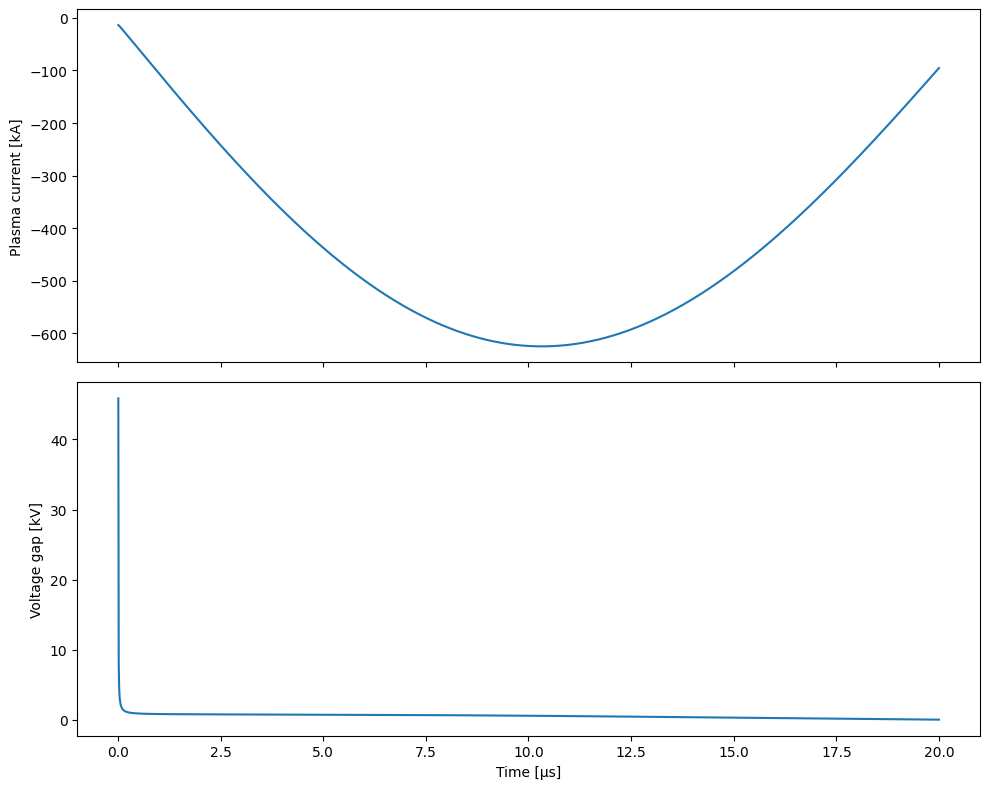

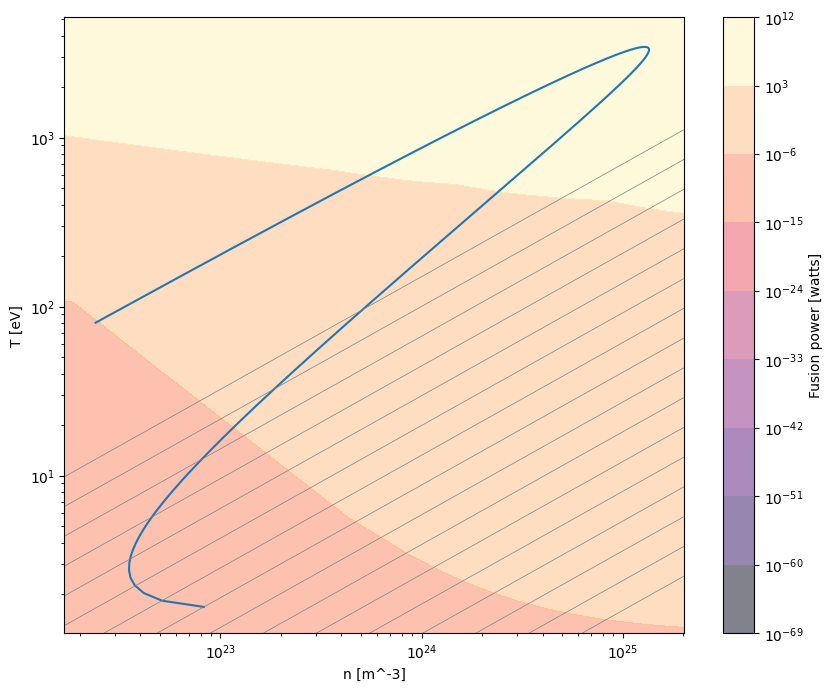

In [66]:
with Tesseract.from_image("tanh_sheath") as sheath_tx:
    with Tesseract.from_tesseract_api(tesseract_api) as tx:
        result = tx.apply(dict(
            Vc0=Vc0,
            Ip0=Ip0,
            a0=a0,
            N=N,
            Lp_prime=Lp_prime,
            Lz=Lz,
            R=R, L=L, C=C,
            sheath_tesseract_url=sheath_tx._client.url,
            dt=1e-8,
            t_end=2e-5,
        ))

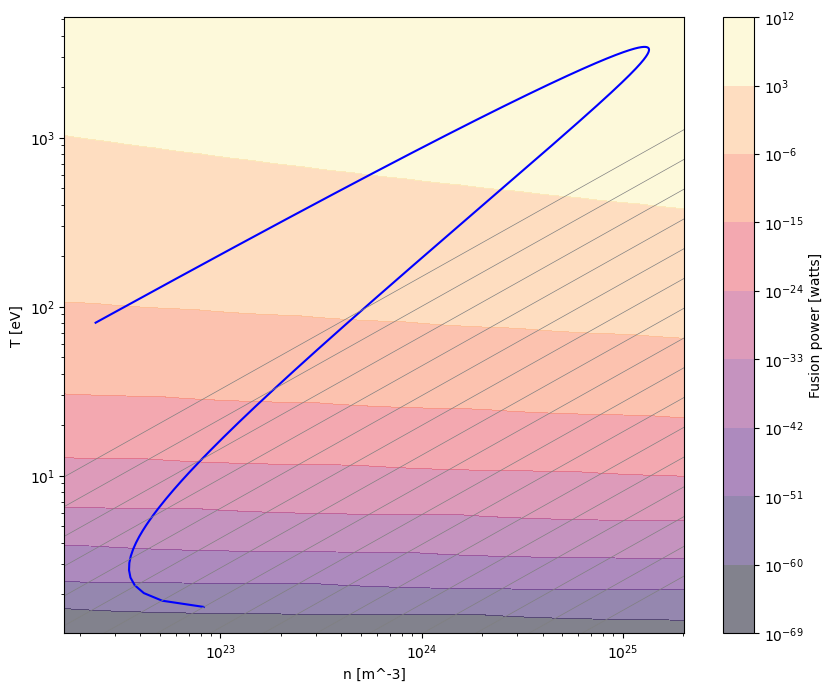

In [67]:
def adiabat_plot(out, N, L):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    n = out["n"]
    T = out["T"]

    ax.loglog(n, T, color='blue')
    Ts = jnp.linspace(0.1*jnp.min(T), 10*jnp.max(T))
    for adiabat in 1.5**jnp.arange(-8, 8):
        ax.loglog((Ts/T[0])**(1.5) * n[0], Ts * adiabat, color='gray', linewidth=0.5)

    def fusion_power_of(n, T):
        a = jnp.sqrt(N / n / jnp.pi)
        return fusion_power(n, L, a, T)

    ax.set_xlim(0.7*jnp.min(n), 1.5*jnp.max(n))
    ax.set_ylim(0.7*jnp.min(T), 1.5*jnp.max(T))

    Ts = jnp.geomspace(0.7*jnp.min(T), 1.5*jnp.max(T), 100)
    ns = jnp.geomspace(0.7*jnp.min(n), 1.5*jnp.max(n), 100)
    n_mesh, T_mesh = jnp.meshgrid(ns, Ts)
    P_f = fusion_power_of(n_mesh, T_mesh)
    cf = ax.contourf(n_mesh, T_mesh, P_f, alpha=0.5,
                     cmap=plt.cm.magma, norm=mpl.colors.LogNorm(vmin=P_f.min(), vmax=P_f.max()))

    ax.set_xlabel("n [m^-3]")
    ax.set_ylabel("T [eV]")

    cbar = fig.colorbar(cf)
    cbar.ax.set_ylabel("Fusion power [watts]")

    return fig

fig = adiabat_plot(result, N, Lz)

[3.31245833e-19 1.16207396e-16 1.37363122e-14 ... 2.47150269e+06
 2.18665652e+06 1.93036836e+06]
[[4.50558304e+01 5.21033812e+01 6.02532970e+01 ... 5.96893956e+07
  6.90259020e+07 7.98228076e+07]
 [4.73360833e+01 5.47403071e+01 6.33026861e+01 ... 6.27102459e+07
  7.25192682e+07 8.38625998e+07]
 [4.97317387e+01 5.75106865e+01 6.65064032e+01 ... 6.58839799e+07
  7.61894319e+07 8.81068438e+07]
 ...
 [5.41451143e+03 6.26143943e+03 7.24084237e+03 ... 7.17307643e+09
  8.29507596e+09 9.59257661e+09]
 [5.68853713e+03 6.57832773e+03 7.60729776e+03 ... 7.53610222e+09
  8.71488558e+09 1.00780521e+10]
 [5.97643114e+03 6.91125359e+03 7.99229928e+03 ... 7.91750056e+09
  9.15594156e+09 1.05880972e+10]]


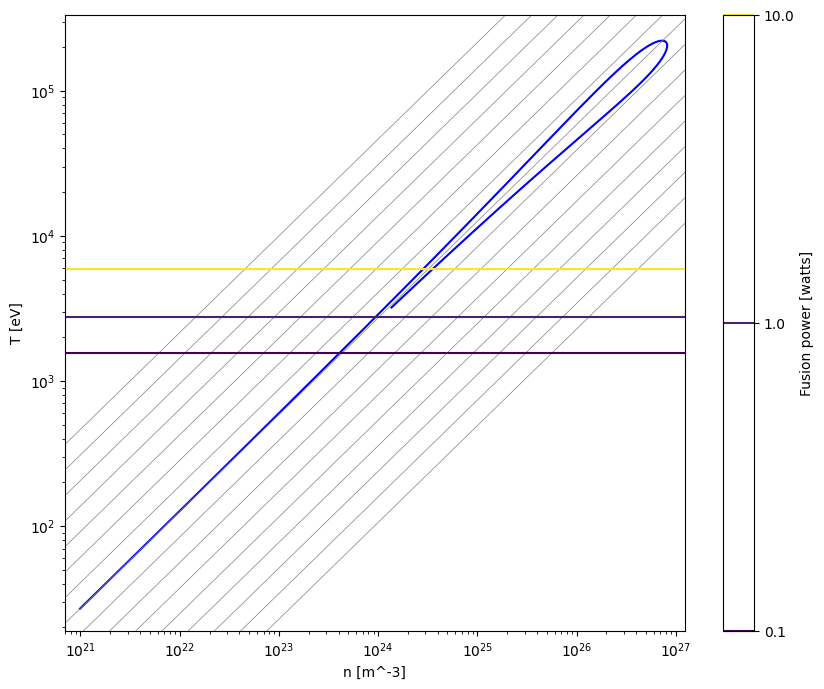

In [56]:
import jpu
ureg = jpu.UnitRegistry()

# Returns the Bremsstrahlung power in units of eV / s
def bremsstrahlung_power(n, L, a, T):
    P_br = n**2 * T**0.5 / (7.69e18)**2 # [ureg.W / m^3]
    vol = L * jnp.pi*a**2
    P_rad = (P_br * vol)
    return P_rad


def adiabat_plot_Q(out, N, L):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    n = out["n"]
    T = out["T"]

    ax.loglog(n, T, color='blue')
    Ts = jnp.linspace(0.1*jnp.min(T), 10*jnp.max(T))
    for adiabat in 1.5**jnp.arange(-8, 8):
        ax.loglog((Ts/T[0])**(1.5) * n[0], Ts * adiabat, color='gray', linewidth=0.5)

    def fusion_power_of(n, T):
        a = jnp.sqrt(N / n / jnp.pi)
        return fusion_power(n, L, a, T)

    def brems_power_of(n, T):
        a = jnp.sqrt(N / n / jnp.pi)
        return bremsstrahlung_power(n, L, a, T)
    
    ax.set_xlim(0.7*jnp.min(n), 1.5*jnp.max(n))
    ax.set_ylim(0.7*jnp.min(T), 1.5*jnp.max(T))

    Ts = jnp.geomspace(0.7*jnp.min(T), 1.5*jnp.max(T), 100)
    ns = jnp.geomspace(0.7*jnp.min(n), 1.5*jnp.max(n), 100)
    n_mesh, T_mesh = jnp.meshgrid(ns, Ts)

    
    P_f = fusion_power_of(n_mesh, T_mesh)
    P_fusion_achieved = fusion_power_of(n, T)
    print(P_fusion_achieved)
    P_brems = brems_power_of(n_mesh, T_mesh)
    print(P_brems)
    Q = P_f / P_brems
    cf = ax.contour(n_mesh, T_mesh, Q, cmap=mpl.cm.viridis,
                   levels=[0.1, 1.0, 10.0])

    ax.set_xlabel("n [m^-3]")
    ax.set_ylabel("T [eV]")

    cbar = fig.colorbar(cf)
    cbar.ax.set_ylabel("Fusion power [watts]")

    return fig

fig = adiabat_plot_Q(result, N, Lz)

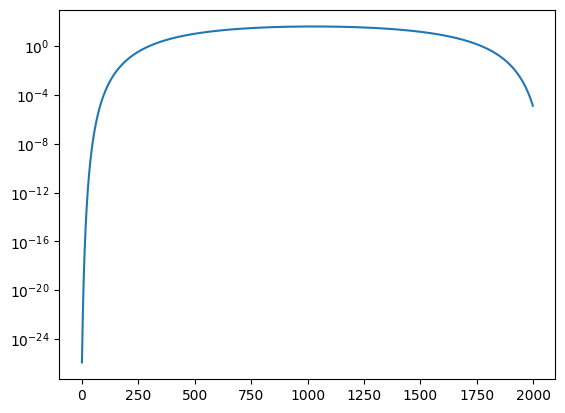

In [64]:
Ip = result['Ip'] * ureg.A
Vp = result['Vp'] * ureg.V
P_ohm = (Ip*Vp).to(ureg.W)

T = result['T']
n = result['n']

def fusion_power_of(n, T):
    a = jnp.sqrt(N / n / jnp.pi)
    return fusion_power(n, Lz, a, T)
    
def brems_power_of(n, T):
    a = jnp.sqrt(N / n / jnp.pi)
    return bremsstrahlung_power(n, Lz, a, T)
    
P_brems = brems_power_of(n, T)
P_fusion = fusion_power_of(n, T)

Q = P_fusion / (P_brems - P_ohm.magnitude)
plt.semilogy(Q)